# Clean Air Markets Data

This notebook demonstrates how we can extract data from EPA's clean air markets program. Instead of using another Python library to access the data, we will directly query the data using the Python `requests` package.

[Link to CAMS data from EPA](https://www.epa.gov/power-sector/cam-api-portal#/swagger/emissions-mgmt)


This notebook was inspired by the examples provided by EPA on [GitHub](https://github.com/USEPA/cam-api-examples/blob/main/Python/bulk_data_api_demo.py).

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
import requests
import json
import os
import datetime as dt
from tqdm import trange, tqdm
import UCSmpl

pd.options.display.max_columns = None

# load the environment variables
load_dotenv()

True

In [2]:
cems_key = os.environ.get("CEMS_API_KEY")

# Streaming API

* maximum rows per page: 500
* there is no download limit on APIs

[API Portal](https://www.epa.gov/power-sector/cam-api-portal#/frequent-questions)

In [4]:
streamingUrl = "https://api.epa.gov/easey/streaming-services/emissions/apportioned/hourly"
frames = []

MAX_PAGES = 1000
for page in tqdm(range(1,MAX_PAGES), unit='page'):
    # print(page)
    parameters = {
        'api_key': cems_key,
        'beginDate': '2023-01-01',
        'endDate': '2023-01-03',
        'stateCode':'NH',
        'operatingHoursOnly':'false',
        # 'programCodeInfo': 'CSOSG2|CSOSG3',
        'page':page,
        'perPage':500,
    }
    
    # making get request using the emissions/apportioned/hourly endpoint
    streamingResponse = requests.get(streamingUrl, params=parameters)
    
    df = pd.DataFrame(streamingResponse.json())
    frames.append(df)
    
    if len(df) < 500:
        print('Reached the end!')
        break


# streamingResponse

  0%|          | 1/999 [00:02<46:22,  2.79s/page]

Reached the end!


In [5]:
full_df = pd.concat(frames, axis=0)

In [6]:
full_df['time'] = pd.to_datetime(full_df['date'] + " " + full_df['hour'].apply(str), format="%Y-%m-%d %H")

In [9]:
full_df['facilityName'].unique()

array(['Merrimack', 'Schiller', 'Newington', 'Granite Ridge Energy',
       'Newington Energy', 'Burgess BioPower'], dtype=object)

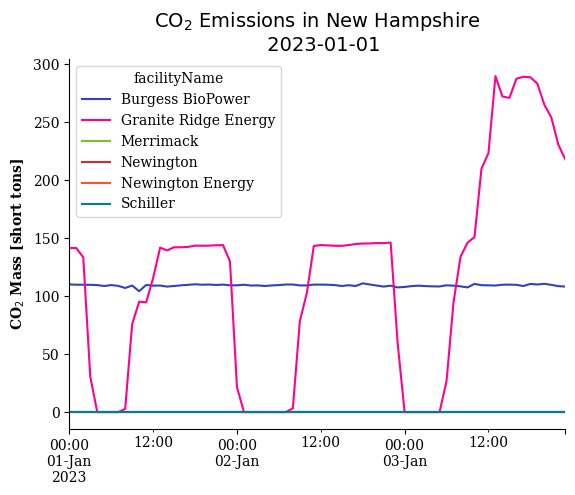

In [22]:
with plt.style.context("ucs_light"):
    fig, ax = plt.subplots()
    full_df.pivot_table(index="time", columns="facilityName",values="co2Mass",aggfunc='sum').plot(ax=ax)
    ax.set_ylabel(r"CO$_2$ Mass [short tons]")
    ax.set_xlabel("")
    ax.set_title("CO$_2$ Emissions in New Hampshire \n  2023-01-01", fontdict=dict(family='sans serif',fontsize=14))

In [10]:
full_df = full_df.set_index('time', drop=True)\
        .drop(columns=['date','hour'])

In [11]:
full_df.set_index(['facilityId', 'unitId'],append=True, inplace=True)

In [12]:
full_df.index.get_level_values('facilityId').unique().to_list()

[2364, 2367, 8002, 55170, 55661, 58054]

(0.0, 255.0)

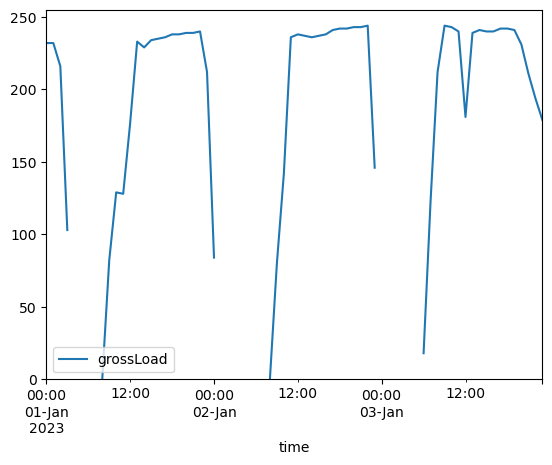

In [19]:
full_df.xs((slice(None),55170, '0001'))[['grossLoad']].plot()
plt.ylim(0,255)

(0.0, 0.065)

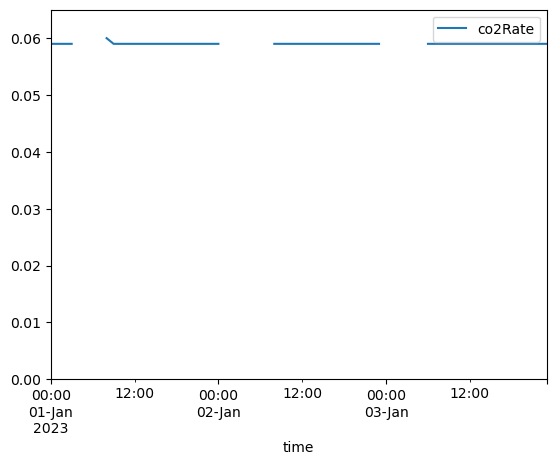

In [17]:
full_df.xs((slice(None), 55170, '0001'))[['co2Rate']].plot()
plt.ylim(0,0.065)